## Find Best Locations in New York to open Goila Butter Chicken's Cloud Kitchen

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Extract New York Neighborhoods and Get Location Coordinates</a>
    - Use New York JSON file which contains list of boroughs, neighborhoods and coordinates
    - Visualize the neighborhoods using Folium
    
      
2.  <a href="#item1">Explore and Cluster the Neighborhoods</a>
    - Use Foursquare API to get nearby venues and venue categories.
    - Filter on neighborhoods with 100 or more venues
    - Cluster the neighborhoods based on venue categories, using K-means algorithm 
    - Visualize the clustered neighborhoods using Folium
    - Get the top 10 most common venue categories in each neighborhood
    - Examine each cluster and determine how they are distinguished
  
  
3.  <a href="#item1">Recommend Locations to open Cloud Kitchen</a>  
    - Find top 5 neighborhoods with Indian Restaurants
    - Find the neighborhoods with Indian Restaurants amongst Top 10 venues
    - Observations and Conclusion

<a href="#item2"></a>

</font>
</div>

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
import json
from bs4 import BeautifulSoup

import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

from sklearn.cluster import KMeans

## Extract New York Neighborhoods and Get Location Coordinates

#### Use New York JSON file which contains list of boroughs, neighborhoods and coordinates

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [3]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

nyc_neighborhoods = pd.DataFrame(columns=column_names)

for neighbor in newyork_data['features']:
    borough = neighbor['properties']['borough'] 
    neighborhood = neighbor['properties']['name']
    latitude = neighbor['geometry']['coordinates'][1]
    longitude = neighbor['geometry']['coordinates'][0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'Borough': borough, 
                                          'Neighborhood': neighborhood,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)
nyc_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
nyc_neighborhoods['Borough'].unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

In [5]:
nyc_neighborhoods.shape

(306, 4)

In [6]:
address = 'New York City, NY'

url = 'https://nominatim.openstreetmap.org/search?q={}&format=jsonv2'.format(address)
response = requests.get(url)
content = response.json()

latitude = float(content[0]['lat'])
longitude = float(content[0]['lon'])
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


#### Visualize the neighborhoods using Folium

In [8]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyc_neighborhoods['Latitude'], nyc_neighborhoods['Longitude'], nyc_neighborhoods['Borough'], nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next, we will use the Foursquare API to explore the neighborhoods in above filtered boroughs and segment them.

## Explore and Cluster the Neighborhoods

#### Use Foursquare API to get nearby venues and venue categories

In [9]:
ID = '*****' # Foursquare ID
SECRET = '*****' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # Foursquare API limit value

In [10]:
cols = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

neighborhood_venues = pd.DataFrame(columns = cols)

In [11]:
for columns, neighborhood in nyc_neighborhoods.iterrows():
    radius = 1000
    neigborhood_name = neighborhood['Neighborhood']
    neighborhood_lat = neighborhood['Latitude']
    neighborhood_lon = neighborhood['Longitude']
        
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'\
    .format(ID, KEY, VERSION, neighborhood_lat, neighborhood_lon, radius, LIMIT)

    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    
    for v in venues:
        neighborhood_venues = neighborhood_venues.append({'Neighborhood': neigborhood_name, 
                                              'Neighborhood Latitude': neighborhood_lat,
                                              'Neighborhood Longitude': neighborhood_lon,
                                              'Venue': v['venue']['name'],
                                              'Venue Latitude': v['venue']['location']['lat'],
                                              'Venue Longitude': v['venue']['location']['lng'],
                                              'Venue Category': v['venue']['categories'][0]['name']}, ignore_index=True)

neighborhood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


In [12]:
# Count of venues
neighborhood_venues.shape

(20528, 7)

In [13]:
# Count of unique venues
len(neighborhood_venues['Venue Category'].unique())

485

In [14]:
# Count of unique venue category in each neighborhood
neighborhood_venues.groupby('Neighborhood')['Venue Category'].count()

Neighborhood
Allerton                      61
Annadale                      11
Arden Heights                 23
Arlington                     21
Arrochar                      23
Arverne                       40
Astoria                      100
Astoria Heights               79
Auburndale                   100
Bath Beach                    96
Battery Park City            100
Bay Ridge                    100
Bay Terrace                   90
Baychester                    97
Bayside                      100
Bayswater                      8
Bedford Park                  71
Bedford Stuyvesant           100
Beechhurst                    55
Bellaire                      52
Belle Harbor                  27
Bellerose                     54
Belmont                      100
Bensonhurst                  100
Bergen Beach                   9
Blissville                    72
Bloomfield                    28
Boerum Hill                  100
Borough Park                  63
Breezy Point                  

#### Filter on neighborhoods with 100 or more venues

In [36]:
neighborhoods_venues_100 = neighborhood_venues.groupby('Neighborhood')['Venue Category'].count().to_frame()

neighborhoods_venues_100_list = neighborhoods_venues_100.index[neighborhoods_venues_100['Venue Category'] >= 100].to_list()

In [48]:
len(neighborhoods_venues_100_list)

98

In [43]:
neighborhood_venues = neighborhood_venues[neighborhood_venues['Neighborhood'].isin(neighborhoods_venues_100_list)]

In [44]:
neighborhood_venues.shape

(9964, 7)

We are left with 98 neighborhoods (out of 302), which still account for ~50% of venues.  
We will use this filtered data for further exploration and recommendation

#### Cluster the neighborhoods based on venue categories, using K-means algorithm

In [50]:
# one hot encoding
venues_encoded = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")
venues_encoded.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreati

In [52]:
# add neighborhood column back to dataframe at first position
venues_encoded.insert(0, 'Neighborhood', neighborhood_venues['Neighborhood'].values)

venues_encoded.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoo

In [54]:
venues_encoded.shape

(9964, 422)

In [56]:
venues_encoded = venues_encoded.groupby('Neighborhood').mean().reset_index()
venues_encoded.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Baggage Locker,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Kofte Place,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoo

In [57]:
venues_encoded.shape

(98, 422)

In [58]:
X = venues_encoded.drop('Neighborhood', axis=1)

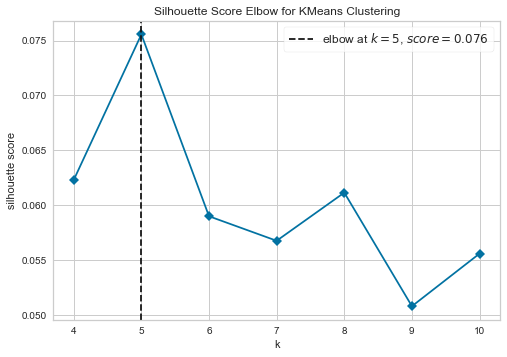

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
# Find best value of k for clustering,using Elbow Plot

from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(init='k-means++', n_init=5, random_state=3)
visualizer = KElbowVisualizer(kmeans, k=(4,11), metric='silhouette', timings=False)
visualizer.fit(X)       
visualizer.show()

k=5 gives the best score, so we will create 5 clusters

In [91]:
# run k-means clustering
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=5, random_state=3)
kmeans.fit(X)

# check cluster labels generated for each row in the dataframe
set(kmeans.labels_)

{0, 1, 2, 3, 4}

In [147]:
# add Cluster Labels to Neighborhoods Data 
nyc_clusters = nyc_neighborhoods[nyc_neighborhoods['Neighborhood'].isin(neighborhoods_venues_100_list)].copy()

In [149]:
nyc_clusters.shape

(98, 4)

In [150]:
nyc_clusters.insert(0, 'Cluster', kmeans.labels_)
nyc_clusters.head()

,Cluster,Borough,Neighborhood,Latitude,Longitude
5,2,Bronx,Kingsbridge,40.881687,-73.902818
16,0,Bronx,Fordham,40.860997,-73.896427
33,1,Bronx,Morris Park,40.847549,-73.850402
34,0,Bronx,Belmont,40.857277,-73.888452
46,3,Brooklyn,Bay Ridge,40.625801,-74.030621


In [153]:
nyc_clusters.groupby('Cluster')['Neighborhood'].count()

Cluster
0    21
1    40
2    22
3    10
4     5
Name: Neighborhood, dtype: int64

#### Visualize the clustered neighborhoods using Folium

In [152]:
# create map of london
nyc_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_clusters['Latitude'], nyc_clusters['Longitude'], nyc_clusters['Neighborhood'], nyc_clusters['Cluster']):
    label = folium.Popup(str(poi) + ' :Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(nyc_clusters_map)
       
nyc_clusters_map

Now, continuing further we will find most common venues of in these neighborhoods and see what is common within each cluster

#### Get the top 10 most common venue categories in each neighborhood

In [154]:
cols = ['Neighborhood'] + ['Most Common Venue '+str(i) for i in range(1,11)]

neighborhood_top_venues = pd.DataFrame(columns=cols)

unique_neighborhoods = neighborhood_venues['Neighborhood'].unique()

for neighbor in unique_neighborhoods:
    df = neighborhood_venues[neighborhood_venues['Neighborhood'] == neighbor]
    top_venues = df['Venue Category'].value_counts().sort_values(ascending=False).head(10).index.to_list()
    
    if len(top_venues) >= 10:
        
        neighborhood_top_venues = neighborhood_top_venues.append({cols[0]:neighbor,
                                                              cols[1]:top_venues[0],
                                                              cols[2]:top_venues[1],
                                                              cols[3]:top_venues[2],
                                                              cols[4]:top_venues[3],
                                                              cols[5]:top_venues[4],
                                                              cols[6]:top_venues[5],
                                                              cols[7]:top_venues[6],
                                                              cols[8]:top_venues[7],
                                                              cols[9]:top_venues[8],
                                                              cols[10]:top_venues[9]}, ignore_index=True)
        
neighborhood_top_venues.head()

,Neighborhood,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
0,Kingsbridge,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Donut Shop,Diner,Coffee Shop,Bank,Café,Park
1,Fordham,Italian Restaurant,Pizza Place,Spanish Restaurant,Diner,Deli / Bodega,Coffee Shop,Donut Shop,Mobile Phone Shop,Clothing Store,Dessert Shop
2,Morris Park,Pizza Place,Sandwich Place,Pharmacy,Italian Restaurant,Gym,Bar,Bank,Coffee Shop,Spanish Restaurant,Donut Shop
3,Belmont,Italian Restaurant,Pizza Place,Bakery,Deli / Bodega,Dessert Shop,Zoo,Exhibit,Latin American Restaurant,Garden,Shoe Store
4,Bay Ridge,Pizza Place,Spa,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Bakery,Bagel Shop,Coffee Shop,Middle Eastern Restaurant,Diner


In [155]:
neighborhood_top_venues.shape

(98, 11)

#### Examine top 3 clusters and determine how they are distinguished

In [157]:
nyc_cluster_venues = pd.merge(left=nyc_clusters, right=neighborhood_top_venues, how='left', on='Neighborhood')
nyc_cluster_venues.head()

,Cluster,Borough,Neighborhood,Latitude,Longitude,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
0,2,Bronx,Kingsbridge,40.881687,-73.902818,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Donut Shop,Diner,Coffee Shop,Bank,Café,Park
1,0,Bronx,Fordham,40.860997,-73.896427,Italian Restaurant,Pizza Place,Spanish Restaurant,Diner,Deli / Bodega,Coffee Shop,Donut Shop,Mobile Phone Shop,Clothing Store,Dessert Shop
2,1,Bronx,Morris Park,40.847549,-73.850402,Pizza Place,Sandwich Place,Pharmacy,Italian Restaurant,Gym,Bar,Bank,Coffee Shop,Spanish Restaurant,Donut Shop
3,0,Bronx,Belmont,40.857277,-73.888452,Italian Restaurant,Pizza Place,Bakery,Deli / Bodega,Dessert Shop,Zoo,Exhibit,Latin American Restaurant,Garden,Shoe Store
4,3,Brooklyn,Bay Ridge,40.625801,-74.030621,Pizza Place,Spa,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Bakery,Bagel Shop,Coffee Shop,Middle Eastern Restaurant,Diner


In [158]:
# Cluster 0
nyc_cluster_venues[nyc_cluster_venues['Cluster'] == 0]

,Cluster,Borough,Neighborhood,Latitude,Longitude,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
1,0,Bronx,Fordham,40.860997,-73.896427,Italian Restaurant,Pizza Place,Spanish Restaurant,Diner,Deli / Bodega,Coffee Shop,Donut Shop,Mobile Phone Shop,Clothing Store,Dessert Shop
3,0,Bronx,Belmont,40.857277,-73.888452,Italian Restaurant,Pizza Place,Bakery,Deli / Bodega,Dessert Shop,Zoo,Exhibit,Latin American Restaurant,Garden,Shoe Store
23,0,Brooklyn,Clinton Hill,40.693229,-73.967843,Italian Restaurant,Pizza Place,Coffee Shop,Playground,Wine Shop,Thai Restaurant,Japanese Restaurant,Mexican Restaurant,Cocktail Bar,Diner
28,0,Brooklyn,East Williamsburg,40.708492,-73.938858,Bar,Cocktail Bar,Coffee Shop,Bakery,Thrift / Vintage Store,Café,Concert Hall,Deli / Bodega,Italian Restaurant,Gay Bar
31,0,Brooklyn,Fort Hamilton,40.614768,-74.031979,Pizza Place,Bagel Shop,Japanese Restaurant,Bar,Italian Restaurant,Cosmetics Shop,Gym / Fitness Center,Spa,Middle Eastern Restaurant,Grocery Store
35,0,Manhattan,Hamilton Heights,40.823604,-73.949688,Coffee Shop,Bar,Mexican Restaurant,Café,Park,Yoga Studio,Cocktail Bar,Sushi Restaurant,Boutique,Indian Restaurant
37,0,Manhattan,Central Harlem,40.815976,-73.943211,Southern / Soul Food Restaurant,Café,African Restaurant,American Restaurant,Pizza Place,Bar,French Restaurant,Seafood Restaurant,Cocktail Bar,Gym / Fitness Center
38,0,Manhattan,East Harlem,40.792249,-73.944182,Pizza Place,Bakery,Mexican Restaurant,Café,Thai Restaurant,Deli / Bodega,Italian Restaurant,Park,Fountain,Cocktail Bar
40,0,Manhattan,Yorkville,40.775930,-73.947118,Ice Cream Shop,Italian Restaurant,Coffee Shop,Gym,Wine Shop,Pizza Place,Gym / Fitness Center,Bagel Shop,Bar,Indian Restaurant
49,0,Manhattan,Greenwich Village,40.726933,-73.999914,Italian Restaurant,Coffee Shop,Spa,Sushi Restaurant,Pizza Place,American Restaurant,Sandwich Place,Café,Bookstore,Gym


In [159]:
# Cluster 1
nyc_cluster_venues[nyc_cluster_venues['Cluster'] == 1]

,Cluster,Borough,Neighborhood,Latitude,Longitude,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
2,1,Bronx,Morris Park,40.847549,-73.850402,Pizza Place,Sandwich Place,Pharmacy,Italian Restaurant,Gym,Bar,Bank,Coffee Shop,Spanish Restaurant,Donut Shop
8,1,Brooklyn,Sheepshead Bay,40.586890,-73.943186,Sushi Restaurant,Italian Restaurant,Russian Restaurant,Turkish Restaurant,Café,Bank,Mobile Phone Shop,Dessert Shop,Sandwich Place,Seafood Restaurant
10,1,Brooklyn,Crown Heights,40.670829,-73.943291,Café,Southern / Soul Food Restaurant,Pizza Place,Bar,Coffee Shop,Caribbean Restaurant,Grocery Store,Japanese Restaurant,Lounge,Deli / Bodega
12,1,Brooklyn,Prospect Heights,40.676822,-73.964859,Bar,Thai Restaurant,Wine Shop,Restaurant,Cocktail Bar,Coffee Shop,New American Restaurant,Mexican Restaurant,Sushi Restaurant,Plaza
14,1,Brooklyn,Bushwick,40.698116,-73.925258,Bar,Cocktail Bar,Coffee Shop,Pizza Place,Mexican Restaurant,Latin American Restaurant,Grocery Store,Deli / Bodega,Yoga Studio,Music Venue
15,1,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,Coffee Shop,Bar,Café,Pizza Place,Wine Shop,Deli / Bodega,Cocktail Bar,Mexican Restaurant,Discount Store,Juice Bar
16,1,Brooklyn,Brooklyn Heights,40.695864,-73.993782,Park,Pizza Place,Coffee Shop,Wine Shop,Italian Restaurant,Restaurant,Cocktail Bar,Yoga Studio,Pier,Grocery Store
17,1,Brooklyn,Cobble Hill,40.687920,-73.998561,Bakery,Italian Restaurant,Cocktail Bar,Bar,Pizza Place,Yoga Studio,Coffee Shop,Wine Shop,Bagel Shop,Food & Drink Shop
18,1,Brooklyn,Carroll Gardens,40.680540,-73.994654,Italian Restaurant,Coffee Shop,Bar,Bakery,Pizza Place,Ice Cream Shop,Yoga Studio,Cocktail Bar,Thai Restaurant,Wine Bar
26,1,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,Caribbean Restaurant,Pizza Place,Bakery,Café,Coffee Shop,Liquor Store,Wine Shop,Park,Pharmacy,Music Venue


In [160]:
# Cluster 2
nyc_cluster_venues[nyc_cluster_venues['Cluster'] == 2]

,Cluster,Borough,Neighborhood,Latitude,Longitude,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
0,2,Bronx,Kingsbridge,40.881687,-73.902818,Pizza Place,Mexican Restaurant,Bar,Sandwich Place,Donut Shop,Diner,Coffee Shop,Bank,Café,Park
5,2,Brooklyn,Bensonhurst,40.611009,-73.995180,Bank,Bakery,Pizza Place,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Sandwich Place,Donut Shop,Bagel Shop,Pharmacy
11,2,Brooklyn,Kensington,40.642382,-73.980421,Pizza Place,Thai Restaurant,Café,Grocery Store,Deli / Bodega,Gas Station,Bakery,Spa,Mexican Restaurant,Ice Cream Shop
13,2,Brooklyn,Williamsburg,40.707144,-73.958115,Pizza Place,Bar,Coffee Shop,American Restaurant,Wine Bar,Yoga Studio,Bakery,Japanese Restaurant,Gym / Fitness Center,Breakfast Spot
19,2,Brooklyn,Gowanus,40.673931,-73.994441,Bar,Coffee Shop,Wine Shop,Pizza Place,Brewery,Italian Restaurant,Mexican Restaurant,Park,Cocktail Bar,American Restaurant
20,2,Brooklyn,Fort Greene,40.688527,-73.972906,Italian Restaurant,Pizza Place,Cocktail Bar,Bar,Playground,Coffee Shop,Performing Arts Venue,Flower Shop,Bookstore,Sandwich Place
22,2,Brooklyn,Coney Island,40.574293,-73.988683,Theme Park Ride / Attraction,Theme Park,Beach,Pizza Place,Supermarket,Bar,Hot Dog Joint,Donut Shop,Monument / Landmark,Gym / Fitness Center
24,2,Brooklyn,Downtown,40.690844,-73.983463,Coffee Shop,Grocery Store,Gym / Fitness Center,Bakery,Bar,Sandwich Place,Chinese Restaurant,French Restaurant,Opera House,Ice Cream Shop
29,2,Brooklyn,North Side,40.714823,-73.958809,Coffee Shop,Pizza Place,Wine Bar,Bakery,Yoga Studio,American Restaurant,Jewelry Store,Bar,Mexican Restaurant,Beer Garden
30,2,Brooklyn,South Side,40.710861,-73.958001,Pizza Place,Wine Bar,Coffee Shop,Bar,Bakery,Cocktail Bar,Yoga Studio,Mexican Restaurant,Jewelry Store,American Restaurant


Looking at the map and analyzing individual clusters, each of them has a good mix of venues and dining options.  
One common thing is all 3 top clusters have mostly venues from Manhattan, Queens and Brooklyn.  
It's difficult to pin point any one cluster, but we can say that neighborhoods in these 3 boroughs are good options.

## Recommend Locations to open Cloud Kitchen

#### Find top 10 neighborhoods with Indian Restaurants

In [162]:
neighborhood_venues_indian = neighborhood_venues[neighborhood_venues['Venue Category'].str.contains('Indian')]
neighborhood_venues_indian.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2921,Bay Ridge,40.625801,-74.030621,Taj Mahal,40.632373,-74.027193,Indian Restaurant
2973,Bay Ridge,40.625801,-74.030621,Bombay Grill,40.622371,-74.031799,Indian Restaurant
3629,Flatbush,40.636326,-73.958401,Ashoka Grill,40.635822,-73.950820,Indian Restaurant
3683,Flatbush,40.636326,-73.958401,Great Indian Curry,40.639798,-73.952516,Indian Restaurant
3864,Kensington,40.642382,-73.980421,Mashallah,40.641231,-73.969321,Indian Restaurant


In [164]:
neighborhood_venues_indian['Neighborhood'].value_counts().head(10)

Woodside            7
Jackson Heights     6
Sutton Place        4
Jamaica Center      4
Long Island City    3
Astoria             3
Yorkville           3
Queensbridge        3
Gramercy            3
Manhattan Valley    3
Name: Neighborhood, dtype: int64

#### Find the neighborhoods with Indian Restaurants amongst Top 10 venues

In [167]:
# Get rows from top venues dataframe where 'Indian Restaurant' is one of the venues
neighborhood_top_venues_indian = nyc_cluster_venues[nyc_cluster_venues.isin(['Indian Restaurant'])]

In [169]:
# Get index of rows as found above
neighborhood_top_venues_indian[neighborhood_top_venues_indian.notnull().any(axis=1)].index

Int64Index([9, 35, 36, 40, 56, 58, 61, 62, 63, 72, 74, 80, 85], dtype='int64')

In [170]:
# Filter rows with above found index
nyc_cluster_venues.iloc[[9, 35, 36, 40, 56, 58, 61, 62, 63, 72, 74, 80, 85]]

,Cluster,Borough,Neighborhood,Latitude,Longitude,Most Common Venue 1,Most Common Venue 2,Most Common Venue 3,Most Common Venue 4,Most Common Venue 5,Most Common Venue 6,Most Common Venue 7,Most Common Venue 8,Most Common Venue 9,Most Common Venue 10
9,3,Brooklyn,Flatbush,40.636326,-73.958401,Pizza Place,Caribbean Restaurant,Coffee Shop,Mexican Restaurant,Bar,Restaurant,Ice Cream Shop,Latin American Restaurant,Juice Bar,Indian Restaurant
35,0,Manhattan,Hamilton Heights,40.823604,-73.949688,Coffee Shop,Bar,Mexican Restaurant,Café,Park,Yoga Studio,Cocktail Bar,Sushi Restaurant,Boutique,Indian Restaurant
36,3,Manhattan,Manhattanville,40.816934,-73.957385,Coffee Shop,Park,Mexican Restaurant,American Restaurant,Italian Restaurant,Seafood Restaurant,Café,Indian Restaurant,Chinese Restaurant,Bar
40,0,Manhattan,Yorkville,40.775930,-73.947118,Ice Cream Shop,Italian Restaurant,Coffee Shop,Gym,Wine Shop,Pizza Place,Gym / Fitness Center,Bagel Shop,Bar,Indian Restaurant
56,1,Manhattan,Manhattan Valley,40.797307,-73.964286,Coffee Shop,Grocery Store,Mexican Restaurant,Bar,Ice Cream Shop,Indian Restaurant,Park,Italian Restaurant,Peruvian Restaurant,Vietnamese Restaurant
58,1,Manhattan,Gramercy,40.737210,-73.981376,Italian Restaurant,New American Restaurant,Juice Bar,American Restaurant,Mexican Restaurant,Coffee Shop,Café,Indian Restaurant,Park,Mediterranean Restaurant
61,1,Queens,Astoria,40.768509,-73.915654,Bar,Greek Restaurant,Pizza Place,Coffee Shop,Seafood Restaurant,Grocery Store,Bakery,Café,Indian Restaurant,Middle Eastern Restaurant
62,1,Queens,Woodside,40.746349,-73.901842,Food Truck,Indian Restaurant,Grocery Store,Bakery,Thai Restaurant,Bar,American Restaurant,Latin American Restaurant,Tibetan Restaurant,Filipino Restaurant
63,1,Queens,Jackson Heights,40.751981,-73.882821,Bakery,South American Restaurant,Mexican Restaurant,Latin American Restaurant,Indian Restaurant,Thai Restaurant,Peruvian Restaurant,Diner,Grocery Store,Coffee Shop
72,4,Queens,Bayside,40.766041,-73.774274,Pizza Place,Bar,Sushi Restaurant,Pharmacy,Korean Restaurant,Asian Restaurant,Indian Restaurant,Sandwich Place,Italian Restaurant,Bakery


In [176]:
nyc_cluster_venues.iloc[[9, 35, 36, 40, 56, 58, 61, 62, 63, 72, 74, 80, 85]]['Neighborhood'].to_list()

['Flatbush',
 'Hamilton Heights',
 'Manhattanville',
 'Yorkville',
 'Manhattan Valley',
 'Gramercy',
 'Astoria',
 'Woodside',
 'Jackson Heights',
 'Bayside',
 'Jamaica Center',
 'Carnegie Hill',
 'Sutton Place']

#### Observations and Conclusion

- Based on cluster analysis, we found Clusters 0,1,2 having the most venues to be most suitable. Also, these 3 top clusters have mostly venues from Manhattan, Queens and Brooklyn.
  

- Top 10 neighborhoods with Indian Restaurants are 'Woodside','Jackson Heights','Sutton Place','Jamaica Center','Long Island City','Astoria','Yorkville','Queensbridge','Gramercy','Manhattan Valley'.
  
  
- We also found that 8 places among above - above 'Yorkville','Manhattan Valley','Gramercy','Astoria','Woodside','Jackson Heights','Jamaica Center','Sutton Place' also have Indian Restaurant amongst their top 10 venues, and these neighborhoods fall in either Manhattan or Queens.  
  
  
- All of these 8 locations seem pretty good, and based on information we have it's difficult filter out further

Based on these observations, we can recommend any of the 8 neighborhoods **(Yorkville, Manhattan Valley, Gramercy, Astoria, Woodside, Jackson Heights, Jamaica Center, Sutton Place)** in **Manhattan or Queens** for opening our new **'Goila Butter Chicken**' Cloud Kitchen.